
**Breast Cancer Analysis and Prediction**
=========================================
     ***SheHacks - Hackathlon***
            By - Peri 

**Dataset is extracted from UCI Machine Learning Repo
(https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)**

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. 
* ID number 
* Diagnosis (M = malignant, B = benign)  
Ten real-valued features are computed for each cell nucleus: 
* radius (mean of distances from center to points on the perimeter) 
* texture (standard deviation of gray-scale values) 
* perimeter 
* area 
* smoothness (local variation in radius lengths) 
* compactness (perimeter^2 / area - 1.0) 
* concavity (severity of concave portions of the contour) 
* concave points (number of concave portions of the contour) 
* symmetry 
* fractal dimension ("coastline approximation" - 1)

## <a id='1.1'>1.1. Load libraries</a> 

In [1]:
# Python libraries
import pandas as pd
import numpy as np

# For visuals
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# ML Algorithm
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

import warnings
warnings.filterwarnings('ignore') #ignore warning messages 

## <a id='1.2'>1.2. Reading the dataset</a>

In [2]:
# Reading dataset
df1 = pd.read_csv('data.csv', low_memory = False)

In [3]:
data = df1.copy()
data.head(5)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

## <a id='1.3'>1.3. Missing values</a>

In [4]:
null_val = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_val.index, y = null_val['Count'] ,opacity = 0.8, marker=dict(color = 'red',
        line=dict(color='#111111',width=1.5)))

layout = dict(title =  "Missing Values from the dataset")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

Most of the features are well balanced except 'Unnamed: 32' it is completely null. It could be due to an error in the dataset, so we can drop that column since it does not have any relevant data.

## <a id='1.4'>1.4. Changing the target value to binary numbers and we will drop the unwanted feature ( col - unnamed: 32 )</a>

In [5]:
# Drop useless variables
data = data.drop(['Unnamed: 32','id'],axis = 1)

# Reassigning target col with binary numbers
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

## <a id='2.1'>2.1. Next step is to explore the dataset and its data type</a> 

In [6]:
data.describe()

diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
count     569.000000  ...    569.000000     569.000000       569.000000   
mean        0.181162  ...     16.269190      25.677223       107.261213   
std         0.027414  ...      4.833242       6.146258        33.602542   
min         0.106000  ...      7.930000      12.020000        50.410000   
25%         0.161900  ...     13.010000      21.080000        84.110000   
50%         0.179200  ...     14.970000      25.410000        97.660000   
75%         0.195700  ...     18.790000      29.720000       125.400000   
max         0.304000  ...     36.040000      49.540000       251.200000   

        area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count   569.000000        569.000000         569.000000       569.000000   
mean    880.583128          0.132369           0.254265         0.272188   
std     569.356993          0.022832           0.157336         0.208624   
min     185.200000          0.071170           0.027290         0.000000   
25%     515.300000          0.116600           0.147200         0.114500   
50%     686.500000          0.131300           0.211900         0.226700   
75%    1084.000000          0.146000           0.339100         0.382900   
max    4254.000000          0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500  

[8 rows x 31 columns]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

## <a id='2.2'>2.2. Distributing the target variable </a> 

In [8]:
M = data[(data['diagnosis'] != 0)]
B = data[(data['diagnosis'] == 0)]

In [9]:
# Countplot 
trace = go.Bar(
                    x = (len(M), len(B)), 
                    y = ['malignant', 'benign'], 
                    orientation = 'h', 
                    opacity = 0.8, 
                    marker = dict(color = [ 'brown', 'lightgreen'],
                                line = dict(color = '#000000',width=1.5)))

layout = dict(title =  'Count of diagnosis variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

# Percentage distribution
trace = go.Pie(
                   labels = ['benign','malignant'], 
                   values = data['diagnosis'].value_counts(), 
                   textfont = dict(size = 15), opacity = 0.8,
                   marker = dict(colors = ['brown', 'lightgreen'], 
                   line = dict(color ='#111111', width=1.5)))


layout = dict(title =  'Distribution of Malignant and Benign')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

## <a id='2.3'>2.3. Features distribution </a> 

In [10]:
def plot_distribution(data_select, size_bin) :  
    tmp1 = M[data_select]
    tmp2 = B[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['malignant', 'benign']
    colors = ['#FF7F50', '#B22222']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot of Malignant and Benign')

Bellow, you can remove the '#' to show all features distribution (except the first line)

In [11]:
#plot distribution 'mean'
plot_distribution('radius_mean', .5)
plot_distribution('texture_mean', .5)
plot_distribution('perimeter_mean', 5)
plot_distribution('area_mean', 10)

In [12]:
plot_distribution('smoothness_mean', 0.5)
plot_distribution('compactness_mean' ,0.5)
plot_distribution('concavity_mean' ,0.5)
plot_distribution('concave points_mean' ,0.5)
plot_distribution('symmetry_mean',0.5)
plot_distribution('fractal_dimension_mean', 0.5)

In [13]:
#plot distribution 'se'
plot_distribution('radius_se', .1)
plot_distribution('texture_se', .1)
plot_distribution('perimeter_se', .5)
plot_distribution('area_se', 5)

In [14]:
plot_distribution('smoothness_se', .5)
plot_distribution('compactness_se', .5)
plot_distribution('concavity_se', .5)
plot_distribution('concave points_se', .5)
plot_distribution('symmetry_se', .5)
plot_distribution('fractal_dimension_se', .5)

In [15]:
#plot distribution 'worst'
plot_distribution('radius_worst', .5)
plot_distribution('texture_worst', .5)
plot_distribution('perimeter_worst', 5)
plot_distribution('area_worst', 10)

## <a id='2.4'>2.4. Correlation matrix</a>

In [16]:
corr = data.corr()
mtx = corr.columns.tolist()
#convert to array
corr_arr  = np.array(corr)

In [17]:
#Plotting
trace = go.Heatmap(z = corr_arr,
                   x = mtx,
                   y = mtx,
                   xgap = 2,
                   ygap = 2,
                   colorscale='Viridis',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for the features in the dataset',
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

Let's check the correlation between few features by pairs based on the correlation heatmap above

## <a id='2.6'>2.5. Positively correlated features</a> 

In [18]:
def plot_var1_var2(var1, var2) :  
    trace0 = go.Scatter(
        x = M[var1],
        y = M[var2],
        name = 'malignant',
        mode = 'markers', 
        marker = dict(color = '#be2596',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = B[var1],
        y = B[var2],
        name = 'benign',
        mode = 'markers',
        marker = dict(color = '#2596be',
                line = dict(
                width = 1)))

    layout = dict(title = var1 +" "+" compared to "+" "+ var2,
                  yaxis = dict(title = var1,zeroline = False),
                  xaxis = dict(title = var2, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

In [19]:
plot_var1_var2('perimeter_mean','radius_worst')
plot_var1_var2('area_mean','radius_worst')
plot_var1_var2('texture_mean','texture_worst')
plot_var1_var2('area_worst','radius_worst')

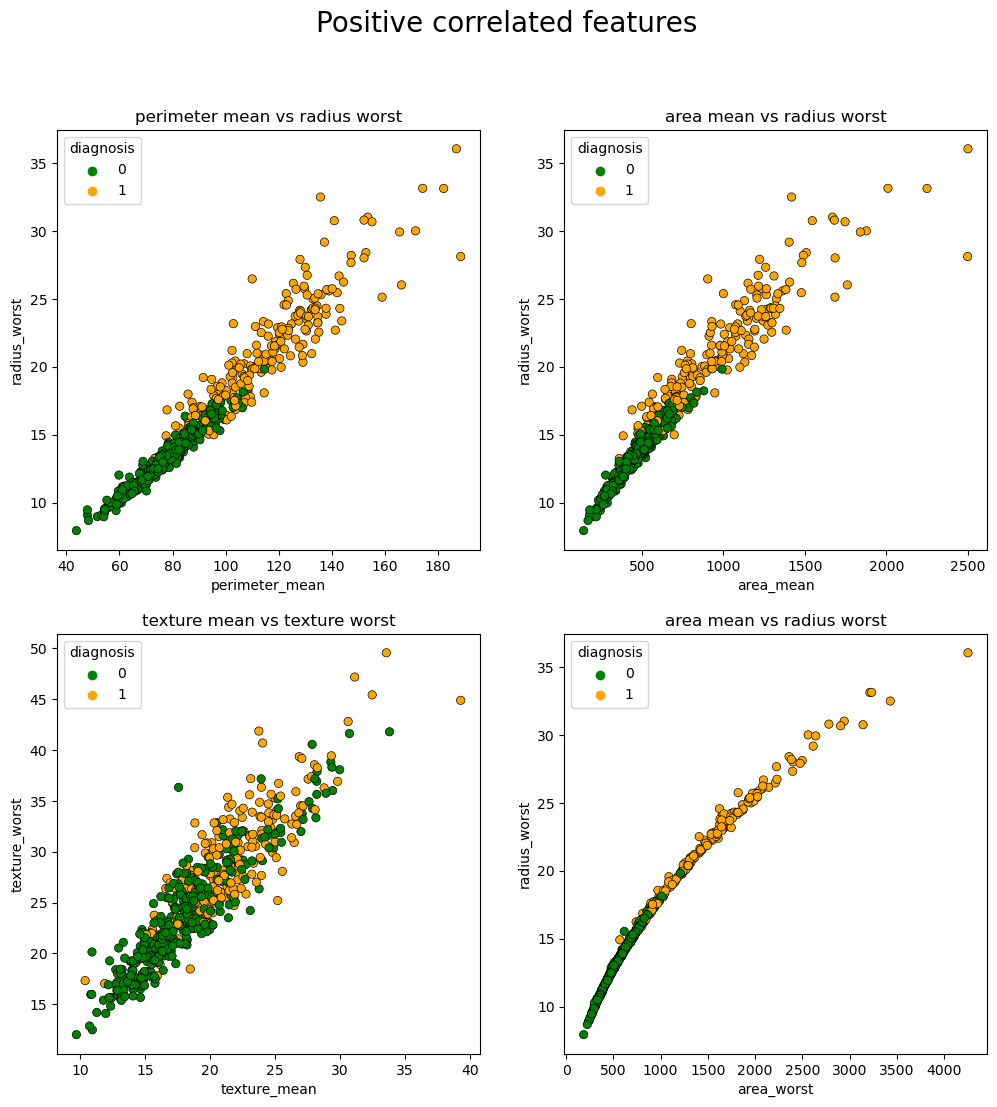

In [20]:
palette ={0 : 'green', 1 : 'orange'}
linecolor = 'black'

fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['perimeter_mean'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('perimeter mean vs radius worst')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('area mean vs radius worst')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['texture_mean'], y = data['texture_worst'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('texture mean vs texture worst')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['area_worst'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('area mean vs radius worst')

fig.suptitle('Positive correlated features', fontsize = 20)
plt.savefig('1')
plt.show()

## <a id='2.7'>2.6. Uncorrelated features</a>

In [21]:
plot_var1_var2('smoothness_mean','texture_mean')
plot_var1_var2('radius_mean','fractal_dimension_worst')
plot_var1_var2('texture_mean','symmetry_mean')
plot_var1_var2('texture_mean','symmetry_se')

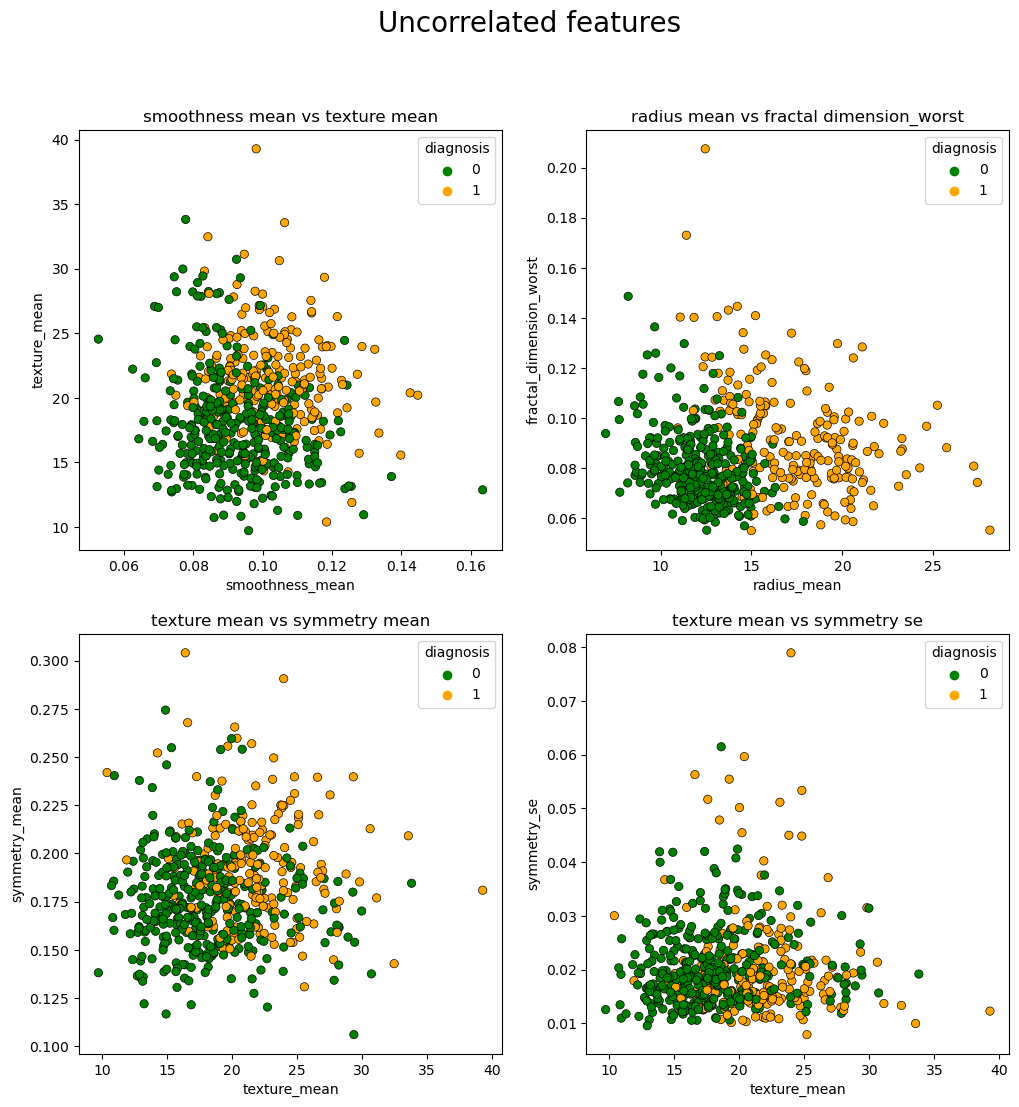

In [22]:
# seaborn version : 
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['smoothness_mean'], y = data['texture_mean'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('smoothness mean vs texture mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_mean'], y = data['fractal_dimension_worst'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('radius mean vs fractal dimension_worst')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['texture_mean'], y = data['symmetry_mean'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('texture mean vs symmetry mean')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['texture_mean'], y = data['symmetry_se'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('texture mean vs symmetry se')

fig.suptitle('Uncorrelated features', fontsize = 20)
plt.savefig('2')
plt.show()

## <a id='2.7'>2.7. Negative correlated features</a>

In [23]:
plot_var1_var2('area_mean','fractal_dimension_mean')
plot_var1_var2('radius_mean','fractal_dimension_mean')
plot_var1_var2('area_mean','smoothness_se')
plot_var1_var2('smoothness_se','perimeter_mean')

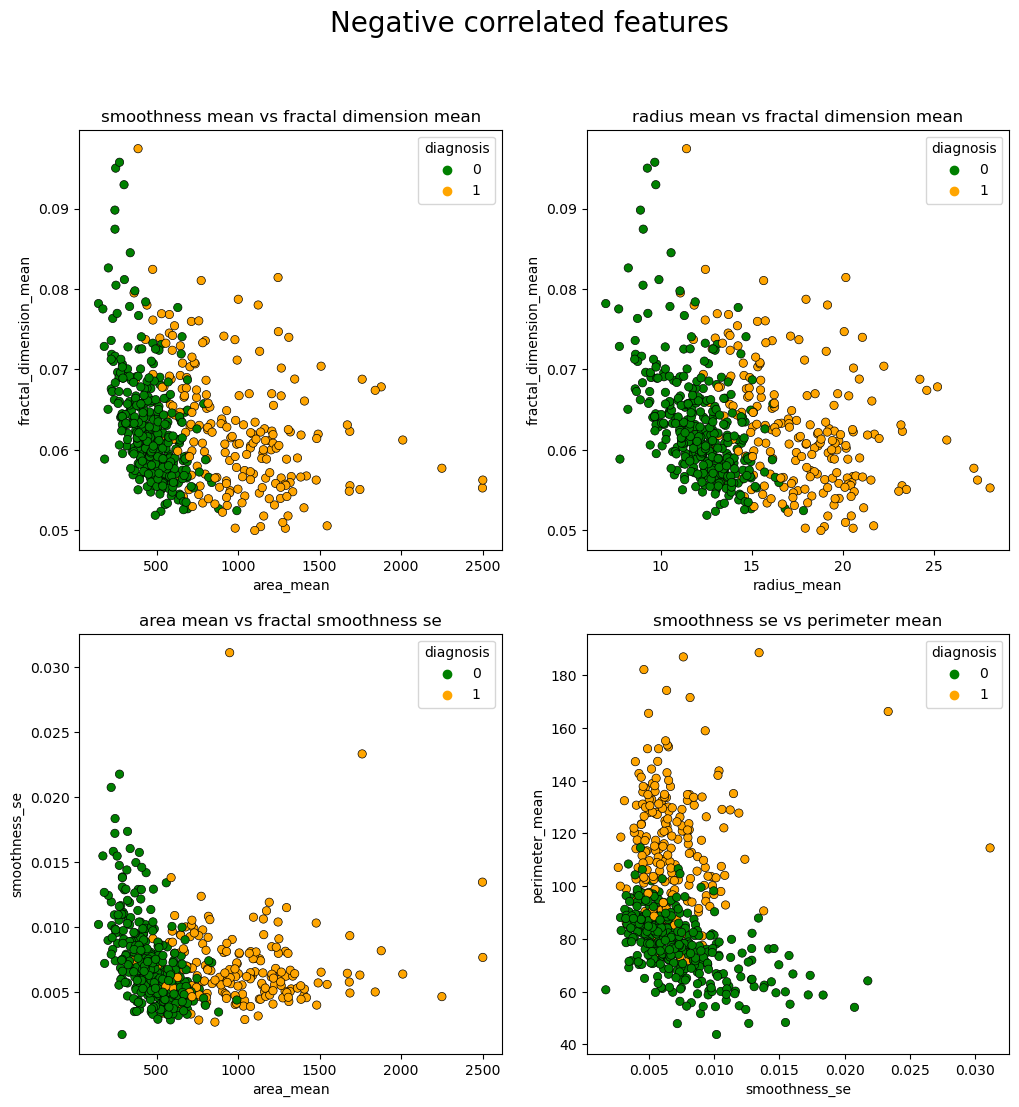

In [24]:
# seaborn version
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['area_mean'], y = data['fractal_dimension_mean'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('smoothness mean vs fractal dimension mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_mean'], y = data['fractal_dimension_mean'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('radius mean vs fractal dimension mean')
plt.subplot(223)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['smoothness_se'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('area mean vs fractal smoothness se')
plt.subplot(224)
ax2 = sns.scatterplot(x = data['smoothness_se'], y = data['perimeter_mean'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor = linecolor)
plt.title('smoothness se vs perimeter mean')

fig.suptitle('Negative correlated features', fontsize = 20)
plt.savefig('3')
plt.show()

## <a href='#3.1'>3.1. Computing Pricipal Component Analysis - PCA</a>

In [25]:
target_pca = data['diagnosis']
data_pca = data.drop('diagnosis', axis=1)

target_pca = pd.DataFrame(target_pca)

X_pca = data_pca.values

X_std = StandardScaler().fit_transform(X_pca)

pca = PCA(svd_solver='full')
pca_std = pca.fit(X_std, target_pca).transform(X_std)

pca_std = pd.DataFrame(pca_std)
pca_std = pca_std.merge(target_pca, left_index = True, right_index = True, how = 'left')
pca_std['diagnosis'] = pca_std['diagnosis'].replace({1:'malignant', 0:'benign'})

## <a id='3.2'>3.2. PCA pie chart</a>

In [26]:
var_pca = pd.DataFrame(pca.explained_variance_ratio_)
var_pca = var_pca.T

col_list = list(v for v in chain(pca_std.columns[6:30])) 
var_pca['diff_vars'] = var_pca[col_list].sum(axis=1)
var_pca.drop(var_pca[col_list],axis=1,inplace=True)
var_pca = var_pca.T

In [27]:
labels = ['var1','var2','var3','var4','var5','var6', 'var7']
colors = ['#2596be', '#9925be', '#be4d25', '#49be25', '#bea925', '#3525be', '#Be6525']

trace = go.Pie(labels = labels, values = var_pca[0].values, opacity = 0.8,
               textfont=dict(size=15),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'PCA : components and with variance')
 
                   
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

## <a id='3.2'>3.3. PCA scatter plot with 2 var </a>

In [28]:
pca = PCA(n_components = 2)

pca_std = pca.fit(X_std, target_pca).transform(X_std)
pca_std = pd.DataFrame(pca_std,columns = ['var1','var2'])
pca_std = pca_std.merge(target_pca,left_index = True,right_index = True,how = 'left')
pca_std['diagnosis'] = pca_std['diagnosis'].replace({1:'malignant', 0:'benign'})

In [29]:
def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_std[pca_std['diagnosis'] == target]['var1'] ,
                        y = pca_std[pca_std['diagnosis'] == target]['var2'],
                        name = target, mode = 'markers',
                        marker = dict(color = color, line = dict(width = 1))
                       )
    return tracer
layout = go.Layout(dict(title = 'PCA Scatter plot ',
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = 'var1',
                                     zerolinewidth = 1,ticklen = 5,gridwidth = 2),
                        
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = 'var2',
                                     zerolinewidth = 1,ticklen = 5,gridwidth = 2),
                        height = 800
                       ))

trace1 = pca_scatter('malignant','green')
trace2 = pca_scatter('benign','orange')
plots = [trace2,trace1]
fig = go.Figure(data = plots,layout = layout)
py.iplot(fig)

## <a id='#3.3'>3.4. PCA scatter plot with 3 var </a>

In [30]:
pca = PCA(n_components = 3)
pca_std = pca.fit(X_std, target_pca).transform(X_std)

pca_std = pd.DataFrame(pca_std,columns = ['var1','var2','var3'])
pca_std = pca_std.merge(target_pca, left_index = True, right_index = True, how = 'left')
pca_std['diagnosis'] = pca_std['diagnosis'].replace({1:'malignant', 0:'benign'})

In [31]:
M_pca = pca_std[(pca_std['diagnosis'] == 'malignant')]
B_pca = pca_std[(pca_std['diagnosis'] == 'benign')]

In [32]:
trace1 = go.Scatter3d(x = M_pca['var1'],
                      y = M_pca['var2'],
                      z = M_pca['var3'],
                      mode = "markers",
                      name = "malignant",
                      marker = dict(size = 3, color = 'orange',line = dict(width = 2))
                     )
trace2 = go.Scatter3d(x = B_pca['var1'],
                      y = B_pca['var2'],
                      z = B_pca['var3'],
                      name = 'benign',
                      mode = 'markers',
                      marker = dict(size = 3, color = 'green',line = dict(width = 2))
                     )



layout = go.Layout(dict(title = 'PCA Scatter plot ',
                        scene = dict(camera = dict(up=dict(x= 0 , y=0, z=0),
                                                   center=dict(x=0, y=0, z=0),
                                                   eye=dict(x=1.25, y=1.25, z=1.25)),
                                     
                                     xaxis  = dict(title = 'var1',
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'),
                                     
                                     yaxis  = dict(title = 'var2',
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  ),
                                     
                                     zaxis  = dict(title = 'var3',
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  )),height = 700))
                  

plots = [trace1,trace2]
fig  = go.Figure(data = plots,layout = layout)
py.iplot(fig)

## <a id='4.1'>4.1. Confusion matrix and peformance metrics</a>

The confusion matrix, also known as the error matrix, allows visualization of the performance of an algorithm :
* true positive (TP) : Malignant tumour correctly identified as malignant
* true negative (TN) : Benign tumour correctly identified as benign
* false positive (FP) : Benign tumour incorrectly identified as malignant 
* false negative (FN) : Malignant tumour incorrectly identified as benign

Metrics : 
* Accuracy : (TP +TN) / (TP + TN + FP +FN)
* Precision : TP / (TP + FP)
* Recall : TP / (TP + FN)


In [33]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

## <a id='4.2'>4.2. Precision – Recall curve</a>

The function below is to show the trade-off between precision and recall for different threshold

In [34]:
# Precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

## <a id='4.3'>4.3. ROC curve</a>

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

In [35]:
# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.title('ROC Curve')
    plt.show();

## <a id='4.4'>4.4. Learning curve</a>

The Learning curve determines cross-validated training and test scores.

In [36]:
# Learning curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    
    return plt

 ## <a id='4.5'>4.5. Cross validation metrics</a>

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it. 

In [37]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.4f (+/- %0.4f)'%(sc, scores.mean(), scores.std()))

# <a id='5'>5. Prepare dataset</a>

## <a id='5.1'>5.1. Defining Variable for train and test var</a>

* y = diagnosis (target)
* X = features (no target) 


In [38]:
# Def X and Y
y = df1['diagnosis']
data2 = df1.drop(columns = ['diagnosis','Unnamed: 32'],axis= 1)
X = data2

print("Shape of y:", y.shape)
print("Shape of x:", X.shape)

Shape of y: (569,)
Shape of x: (569, 31)


In [39]:
data2 = pd.get_dummies(data2, drop_first=True)

## <a id='5.2'>5.2. Standard scaler (X)</a>

Any variable that ranges between 0 and 100 will outweigh a variable that ranges between 0 and 1. Using these variables without standardization in effect gives the variable with the larger range a bigger weight in the analysis

In [40]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## <a id='5.3'>5.3. Train & test split</a>

In [41]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.12, random_state = random_state)

## <a id='6.1'>6.1. Logistic Regression and GridSearch (accuracy)</a>

In [42]:
log_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
The best parameters for using this model is {'C': 0.1, 'penalty': 'l2'}


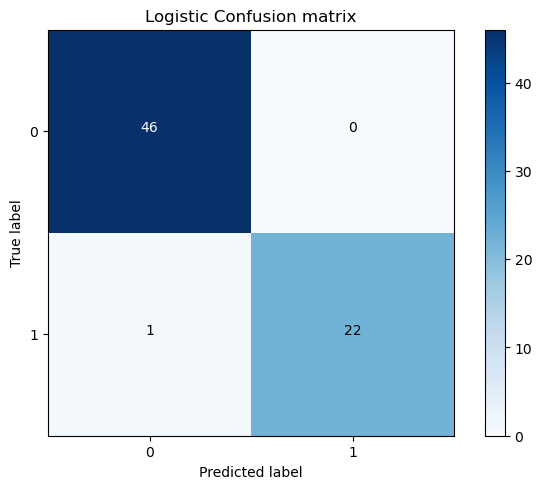

Accuracy  =     0.986
Precision =     1.000
Recall    =     0.957
F1_score  =     0.978


In [43]:
CV_log_clf = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf.fit(X_train, y_train)
y_pred = CV_log_clf.predict(X_test)
y_score = CV_log_clf.decision_function(X_test)

cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

## <a id='6.2'>6.2. RFE : Recursive features elimination</a>

Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_

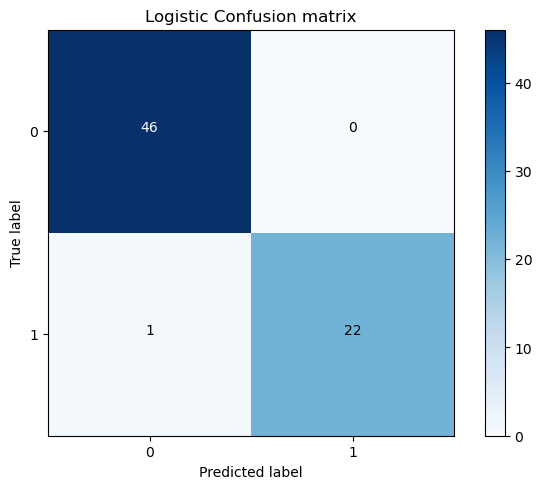

Accuracy  =     0.986
Precision =     1.000
Recall    =     0.957
F1_score  =     0.978


In [44]:
#Logistic regression with RFE
log_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)

selector = RFE(log_clf)
selector = selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)
y_score = selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.show()

show_metrics()


In [45]:
print(selector.support_)
print(selector.ranking_)

[False  True  True  True  True False False False  True False False  True
 False False  True False False False False False False  True  True  True
  True  True False  True  True  True False]
[14  1  1  1  1  8 17  4  1 12  6  1 16  2  1 13  5 15 10  9  3  1  1  1
  1  1  7  1  1  1 11]


## <a id='6.3'>6.3. Compare learning curves and cross validation scores</a> 

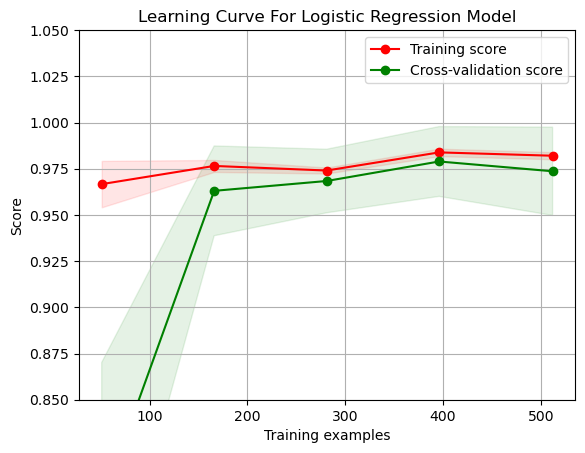

In [46]:
plot_learning_curve(CV_log_clf, 'Learning Curve For Logistic Regression Model', X, y, (0.85,1.05), 10)
plt.savefig('7')
plt.show()

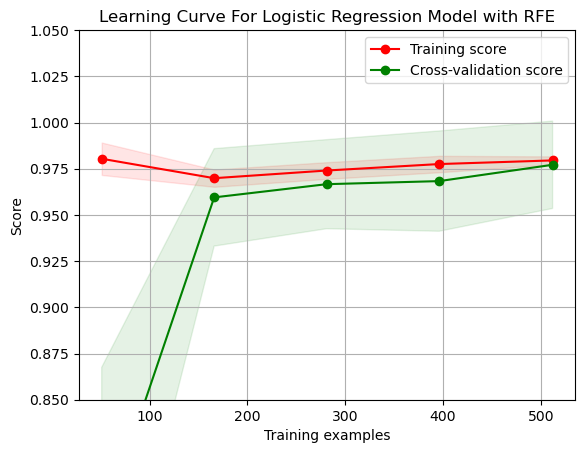

In [47]:
#Learning curve Log with RFE
plot_learning_curve(selector, 'Learning Curve For Logistic Regression Model with RFE', X, y, (0.85,1.05), 10)
plt.show()

In [48]:
# Cross val Log 
cross_log = cross_val_metrics(CV_log_clf)

[accuracy] : 0.9754 (+/- 0.0065)
[precision] : nan (+/- nan)
[recall] : nan (+/- nan)


In [49]:
# Cross val Log with RFE
cross_selector = cross_val_metrics(selector)

[accuracy] : 0.9737 (+/- 0.0111)
[precision] : nan (+/- nan)
[recall] : nan (+/- nan)


With only 15 features and 5 folds, we got an accuracy of 97.4 with a standard deviation of 0.78

## <a id='7.1'>7.1. Logistic Regression  and GridSearch CV to optimise hyperparameters (recall)</a>

In [50]:
log2_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            }

CV_log2_clf = GridSearchCV(estimator = log2_clf, param_grid = param_grid , scoring = 'recall', verbose = 1, n_jobs = -1)
CV_log2_clf.fit(X_train, y_train)

best_parameters = CV_log2_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
The best parameters for using this model is {'C': 0.001, 'penalty': 'l2'}


In [51]:
CV_log2_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)


CV_log2_clf.fit(X_train, y_train)

y_pred = CV_log2_clf.predict(X_test)
y_score = CV_log2_clf.decision_function(X_test)

cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

* Grid search CV accuracy, penalty = l2
* Grid search CV recall,  penalty = l1

In [52]:
# Cross val log2
cross_val_metrics(CV_log2_clf)

[accuracy] : 0.8929 (+/- 0.0309)
[precision] : nan (+/- nan)
[recall] : nan (+/- nan)


## <a id='7.2'>7.2. Voting classifier : log + log2</a> 

In [53]:
voting_clf = VotingClassifier (
        estimators = [('log1', CV_log_clf), ('log_2', CV_log2_clf)],
                     voting='soft', weights = [1, 1])
    
voting_clf.fit(X_train,y_train)

y_pred = voting_clf.predict(X_test)
y_score = voting_clf.predict_proba(X_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
show_metrics()

Accuracy  =     0.986
Precision =     1.000
Recall    =     0.957
F1_score  =     0.978


In [54]:
# Cross val score voting
cross_voting = cross_val_metrics(voting_clf)

[accuracy] : 0.9631 (+/- 0.0065)
[precision] : nan (+/- nan)
[recall] : nan (+/- nan)


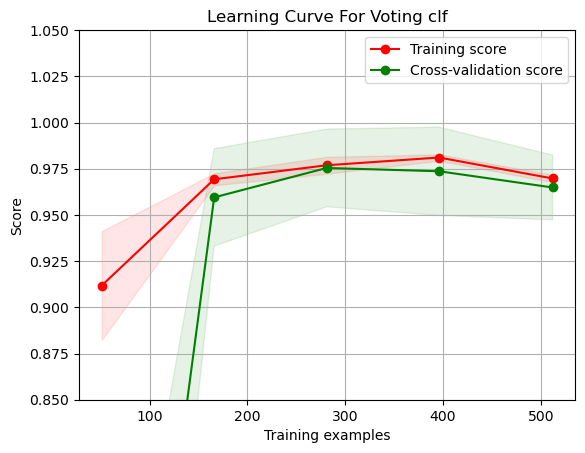

In [55]:
#Learning curve Voting
plot_learning_curve(voting_clf, 'Learning Curve For Voting clf', X, y, (0.85,1.05), 10)
plt.savefig('9')
plt.show()

## <a id='7.3'>7.3. Performance of the model based on accuracy, precision and recall </a>

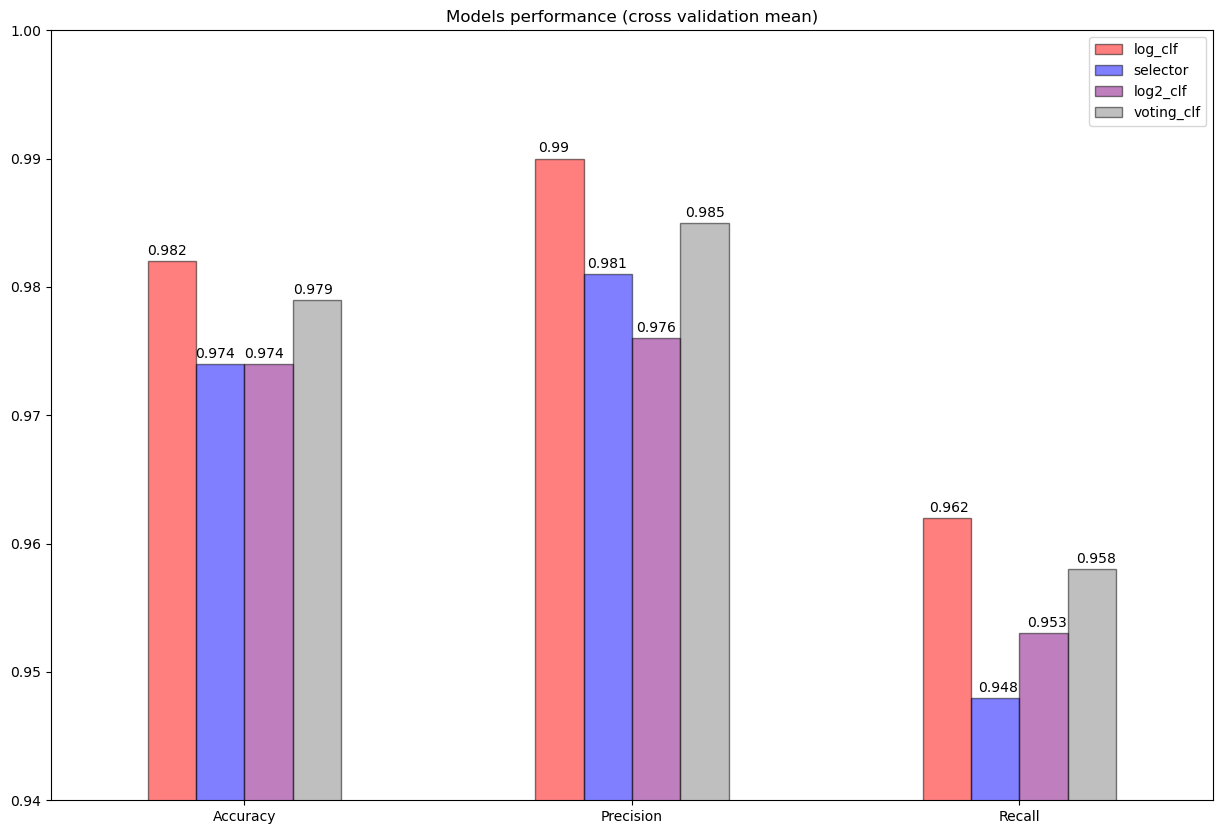

In [56]:
models_metrics = {'log_clf': [0.982, 0.990, 0.962], 
                 'selector': [0.974, 0.981, 0.948],
                 'log2_clf' : [0.974,0.976,0.953],
                 'voting_clf' : [0.979,0.985,0.958]
                }
df = pd.DataFrame(data = models_metrics)
df.rename(index={0:'Accuracy',1:'Precision', 2: 'Recall'}, 
                 inplace=True)
ax = df.plot(kind='bar', figsize = (15,10), ylim = (0.94, 1), 
        color = ['red', 'blue', 'purple', 'grey'],
        rot = 0, title ='Models performance (cross validation mean)',
        edgecolor = 'black', alpha = 0.5)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.0005))
plt.show()

***BASED ON THE ACCURACY - THE HIGHEST IS LOGISITIC REGRESSION -> log clf ***